# Trabajo 4 Aprendizaje automático
## Jorge Pablo Ávila Gómez

### Actividad evaluable
La actividad evaluable va a consistir principalmente en la comparación de clasificaciones
realizadas empleando técnicas de reducción de dimensionalidad.
Se suministra el notebook load_faces.ipynb, disponible en la carpeta code de los documentos
de Alf, en el que se cargan las imágenes de caras obtenidas con el método de scikit-learn
fetch_olivetti_faces. En el notebook se carga el dataset y se hace uso de display(Markdown(faces.DESCR))
para mostrar la documentación asociada al dataset, esta documentación es la misma que aparece
en el enlace anterior, utilizar este método puede proporcionar información interesante si los
creadores del dataset se han preocupado en proporcionarla. En las celdas siguientes las imágenes
se centran y se define un método para mostrar algunas de ellas.

Para la realización de este trabajo se va a partir del notebook suministrado, manteniendo las celdas originales. Después de esas celdas empieza el desarrollo de los diferentes apartados.


# Faces dataset decompositions


This example applies to `olivetti_faces_dataset` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
`decompositions`) .


In [1]:
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
from IPython.display import Markdown

%matplotlib inline

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 4
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
faces = fetch_olivetti_faces(shuffle=True,
                                random_state=rng)
display(Markdown(faces.DESCR))


Automatically created module for IPython interactive environment


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes                                40
    Samples total                         400
    Dimensionality                       4096
    Features            real, between 0 and 1
    =================   =====================

The image is quantized to 256 grey levels and stored as unsigned 8-bit 
integers; the loader will convert these to floating point values on the 
interval [0, 1], which are easier to work with for many algorithms.

The "target" for this database is an integer from 0 to 39 indicating the
identity of the person pictured; however, with only 10 examples per class, this
relatively small dataset is more interesting from an unsupervised or
semi-supervised perspective.

The original dataset consisted of 92 x 112, while the version available here
consists of 64x64 images.

When using these images, please give credit to AT&T Laboratories Cambridge.


In [2]:
n_samples, n_features = faces.data.shape

# global centering
faces_centered = faces.data - faces.data.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [3]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

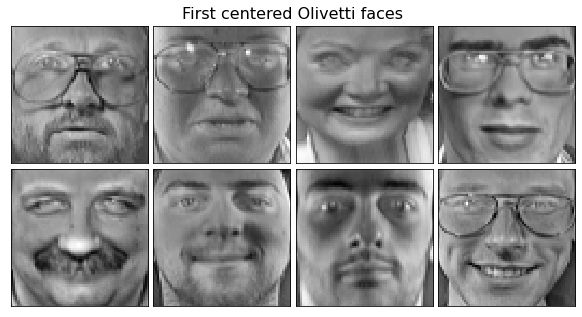

In [4]:
# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

**1. Comprimir las imágenes aplicando PCA de manera que se preserve el 95% de la varianza y mostrar las 8 primeras imágenes originales y descomprimidas. Crear un nuevo dataset con las imágenes comprimidas. ¿Qué número de píxeles quedan al comprimir?**

Preparamos el siguiente código para contestar a las cuestiones planteadas.

El número de pixeles por imagen pasa de 4096 a 144
Varianza preservada:  0.9502677654963918


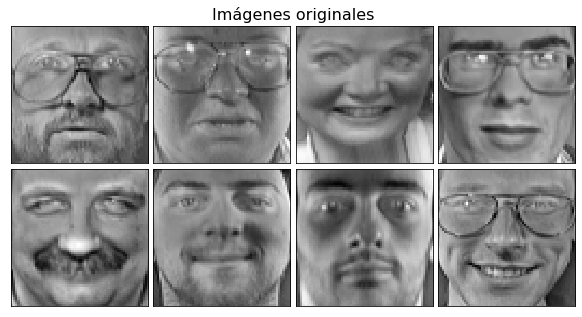

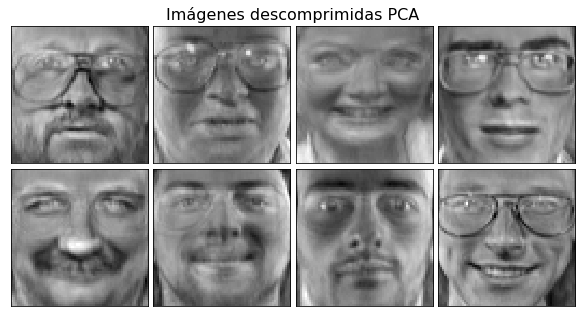

In [5]:
from sklearn.decomposition import PCA

# Prepara el PCA para elegir el número de dimensiones que preserven una varianza del 95%
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(faces_centered)  # Comprimimos las imágenes
print(
    f"El número de pixeles por imagen pasa de {faces_centered.shape[1]} a {X_pca.shape[1]}"
)
print("Varianza preservada: ", sum(pca.explained_variance_ratio_))

X_recovered = pca.inverse_transform(X_pca)  # Imágenes descomprimidas
plot_gallery("Imágenes originales", faces_centered[:8])
plot_gallery("Imágenes descomprimidas PCA", X_recovered[:8])

Hemos usado la funcion `PCA` de sklearn para realizar la compresión de las imágenes. Se ha utilizado el parámetro `n_components = 0.95` el cual sirve para que automáticamente seleccione el número de adecuado de dimensiones que conserve en este caso el 95% de la varianza. Vemos que tras la transformación se ha conservado 0.9502 de la varianza, justo el resultado esperado, pasando de 4096 píxeles por foto a 144.

También mostramos las 8 primeras imágenes antes del proceso de compresión, y las imágenes recuperadas tras la compresión. Vemos que las imágenes son muy parecidas  y se reconocen perfectamente. Se conserva la mayoría de la información, mientras que el número de dimensiones se ha reducido en un 96%.

**2. Lo mismo que en 1. usando LDA.**

Preparamos el siguiente código para contestar a las cuestiones.

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

counter = 1  # Max es 39 (numero de clases -1)
# Bucle para encontrar numero de dimensiones mínimo que mantiene la varianza a 95%
while True:
    lda = LinearDiscriminantAnalysis(n_components=counter)
    lda.fit(faces_centered, faces.target)
    if sum(lda.explained_variance_ratio_) < 0.95:
        counter += 1
    else:
        print(counter, sum(lda.explained_variance_ratio_))
        break

X_lda = lda.transform(faces_centered)
print(
    f"El número de pixeles por imagen pasa de {faces_centered.shape[1]} a {X_lda.shape[1]}"
)
print("Varianza preservada: ", sum(lda.explained_variance_ratio_))

29 0.9523744310998994
El número de pixeles por imagen pasa de 4096 a 29
Varianza preservada:  0.9523744310998994


Hemos usado la funcion `LinearDiscriminantAnalysis` de sklearn para realizar la compresión de las imágenes. Se ha utilizado  un bucle para calcular el número mínimo de dimensiones que conserve el 95% de la varianza. Vemos que tras la transformación se ha conservado 0.9523 de la varianza,y se ha pasado de 4096 a 29 píxeles por foto.

No existe un método para realizar directamente la descompresión de las imágenes, así que tenemos que implementarlo manualmente:

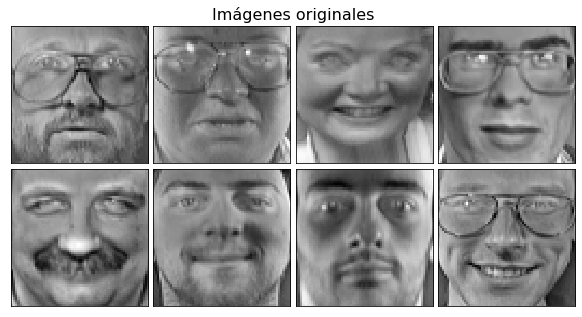

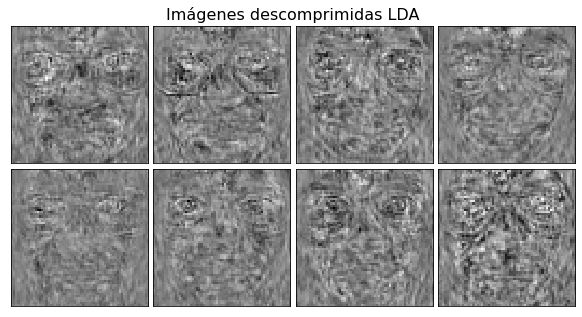

In [7]:
# lda con el número de dimensiones óptimo encontrado en la cenda anterior
lda = LinearDiscriminantAnalysis(n_components=29)
# Comprimimos las imágenes
X_lda = lda.fit(faces_centered, faces.target).transform(faces_centered)
# Pseudomatrix inversa de la matrix de transformación
inv = np.linalg.pinv(lda.scalings_)
# Descompresión de las imágenes usando el número de dimensiones usados en la compresión
X_recovered = np.dot(X_lda, inv[:29,:]) + lda.xbar_

plot_gallery("Imágenes originales", faces_centered[:8])
plot_gallery("Imágenes descomprimidas LDA", X_recovered[:8])

Para entender el proceso de descompresión se han usado diferentes fuentes como por ejemplo: https://stackoverflow.com/questions/42957962/linear-discriminant-analysis-inverse-transform

La matriz de transformación de LDA tiene dimensiones máximas (número de dimensiones, número de clases-1). En este caso el número de clases es 40, por tanto la dimensión de la matriz de transformación es (4096, 39), comparado con las dimensiones de la matriz de transformación de PCA (4096, 400), en LDA las dimensiones son mucho menores. Solo se mantienen 39 direcciones en la matrix de transformación. Al tener menos información la matriz de transformación al descomprimir las imágenes estas pierdan mucha calidad. Prácticamente las caras no son reconocibles. Se pueden detectar algunos detalles, pero para el ojo humano debe ser muy dificil clasificar las caras después del proceso de compresión/descompresión.

**3. Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test
sea un 20% del total, tanto para los datos originales como para los comprimidos con PCA
y LDA. Repasar la documentación de scikit-learn referida a SVM para ver si es conveniente
aplicar transformaciones a los datos.**

Se utiliza la función `train_test_split` para realizar la división en conjunto de entrenamiento y de test. Se utiliza el mismo random_state en las tres divisiones para que en los tres casos los conjuntos de entrenamiento y test esten formados por las mismas imágenes. Además se especifica que se realice una división estratificada por la variable objetivo. Se realiza esta división estratificada para garantizar que tenemos todas las clases en el conjunto de test, porque al tener 40 clases diferentes y solo 80 imágenes en el conjunto de test, podría pasar que no se incluyesen algunas de las clases.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    faces_centered, faces.target, test_size=0.2, random_state=88, stratify=faces.target
)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, faces.target, test_size=0.2, random_state=88, stratify=faces.target
)

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(
   X_lda, faces.target, test_size=0.2, random_state=88, stratify=faces.target
)

In [9]:
# Podemos comprobar que en los tres conjuntos tenemos las mismas imágenes
print(y_train[:5])
print(y_pca_train[:5])
print(y_lda_train[:5])

[36 19  0 16 17]
[36 19  0 16 17]
[36 19  0 16 17]


Los modelos de máquinas de vectores de soporte necesitan que los datos estén escalados porque son métodos que miden distancias y es conveniente que todas las variables estén en el mismo orden de magnitud, así se garantiza que todas las variables tengan la mismo influencia en el modelo. En este caso cada pixel era un número real entre 0 y 1, y además, al principio del notebook se realizó un centrado de las variables para generar faces_centered. De todas formas se va a implementar una pipeline que incluya un paso de StandarScaler para asegurar que las variables se encuentren correctamente escaladas.

**4. Realizar una afinación de hiperparámetros para LinearSVC y SVC con kernel ’rbf’ para la
clasificación de los datos originales, realizando la búsqueda de parámetros como se comentó
en las subsecciones 7.4.1 y 7.4.2 (cambiando SVR por SVC). Usar para el parámetro ’cv’ de GridSearchCV el valor 10. Medir los tiempos en milisegundos de las dos ejecuciones de GridSearchCV. Se recomienda usar multiproceso.**

Para la ejecución de la afinación de hiperparámetros se ha ejecutado el notebook en un entorno de Google Cloud con 16 núcleos. Se ha aprovechado que ofrecen 200 dólares gratis al empezar a usarlo. Ya usé la plataforma junto a un grupo de amigos para la Novartis Datathon de este año (quedamos en quitan posición), como sobró crédito me ha parecido una buena idea usarlo para esta práctica.

Se usa crossvalidation con 8 folds porque nos quedan 320 imágenes en el trainset, en cada fold 320/8 quedan 40 imágenes que da a 1 imagen por clase. Si aumentamos el número de folds quedaría menos de una imagen por clase y nos daría error. GridSearchCV y las demás funciones que usan crossvalidation en sklearn, usan una división estratificada para preparar los folds, por eso pide como requisito que haya al menos 1 imagen por clase en cada fold. Se ha considerado que es un requisito deseable para que en cada iteración se evalue la predicción de todas las clases, por tanto, se ha procedido usando validación cruzada con 8 folds.

Por último, se ha medido el tiempo de ejecución usando la función ``time.time``.

### LinearSVC

In [10]:
# Rango de los parámetros para la primera busqueda
np.logspace(-3, 0.0, num=4)

array([0.001, 0.01 , 0.1  , 1.   ])

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": np.logspace(-3, 0.0, num=4)}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  32 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.1min finished


Tiempo: 369256.60514831543 ms
Best parameters: {'model__C': 0.01}
accuracy: 0.9531


In [12]:
# Rango de los parámetros para la segunda busqueda
np.logspace(-3, -1, num=10)

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": np.logspace(-3, -1, num=10)}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000}ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.8min finished


Tiempo: 633318.4678554535ms
Best parameters: {'model__C': 0.004641588833612777}
accuracy: 0.9625


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
# Rango de los parámetros para la tercera busqueda
np.linspace(0.00278256, 0.00774264, num=10)

array([0.00278256, 0.00333368, 0.0038848 , 0.00443592, 0.00498704,
       0.00553816, 0.00608928, 0.0066404 , 0.00719152, 0.00774264])

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": np.linspace(0.00278256, 0.00774264, num=10)}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000}ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.9min finished


Tiempo: 593394.7286605835ms
Best parameters: {'model__C': 0.00333368}
accuracy: 0.9656


In [16]:
# Evaluación con el conjunto de test
scores_gs.best_estimator_.score(X_test, y_test)

0.9625

### SVC

In [17]:
# Rango de los parámetros para la primera busqueda
rang_c = np.logspace(-7, 3, num=20)
rang_g = np.logspace(-7, 3, num=20)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  6.7min finished


Tiempo: 402222.24283218384 ms
Best parameters: {'model__C': 7.847599703514606, 'model__gamma': 4.281332398719396e-05}
accuracy: 0.9625


In [19]:
# Rango de los parámetros para la segunda busqueda
rang_c = np.logspace(np.log10(2.33572147), np.log10(2.63665090e+01), num=10)
rang_g = np.logspace(np.log10(1.27427499e-05), np.log10(1.43844989e-04), num=10)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.6min finished


Tiempo: 99197.85618782043 ms
Best parameters: {'model__C': 5.239601355204383, 'model__gamma': 8.394147744519818e-05}
accuracy: 0.9625


In [21]:
# Rango de los parámetros para la tercera busqueda
rang_c = np.linspace(4.00257226,  6.85894484, num=10)
rang_g = np.linspace(6.41235481e-05, 1.09884307e-04, num=10)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_train, y_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_train, y_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.6min finished


Tiempo: 98477.0860671997 ms
Best parameters: {'model__C': 4.319946991111111, 'model__gamma': 9.971524946666667e-05}
accuracy: 0.9625


In [23]:
# Evaluación con el conjunto de test
scores_gs.best_estimator_.score(X_test, y_test)

0.9625

**5. Realizar 4. usando los datos comprimidos mediante PCA.**

Realizamos el mismo tipo de busqueda de hiperparámetros pero usando en este caso los datos comprimidas mediante PCA: `X_pca_train` y `y_pca_train`.

### LinearSVC

In [24]:
# Rango de los parámetros para la primera busqueda
rang = np.logspace(-5, 0.0, num=20)
np.logspace(-5, 0.0, num=20)

array([1.00000000e-05, 1.83298071e-05, 3.35981829e-05, 6.15848211e-05,
       1.12883789e-04, 2.06913808e-04, 3.79269019e-04, 6.95192796e-04,
       1.27427499e-03, 2.33572147e-03, 4.28133240e-03, 7.84759970e-03,
       1.43844989e-02, 2.63665090e-02, 4.83293024e-02, 8.85866790e-02,
       1.62377674e-01, 2.97635144e-01, 5.45559478e-01, 1.00000000e+00])

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": rang}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    9.6s finished


Tiempo: 10090.502262115479 ms
Best parameters: {'model__C': 0.004281332398719391}
accuracy: 0.9437


In [26]:
# Rango de los parámetros para la segunda busqueda
rang = np.linspace(2.33572147e-03, 7.84759970e-03, num=20)
np.linspace(2.33572147e-03, 7.84759970e-03, num=20)

array([0.00233572, 0.00262582, 0.00291592, 0.00320602, 0.00349612,
       0.00378622, 0.00407631, 0.00436641, 0.00465651, 0.00494661,
       0.00523671, 0.00552681, 0.00581691, 0.00610701, 0.00639711,
       0.0066872 , 0.0069773 , 0.0072674 , 0.0075575 , 0.0078476 ])

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": rang}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.2s finished


Tiempo: 8738.68179321289 ms
Best parameters: {'model__C': 0.0043664134494736835}
accuracy: 0.9469


In [28]:
# Rango de los parámetros para la tercera busqueda
rang = np.linspace(0.00407631, 0.00465651, num=20)
np.linspace(0.00407631, 0.00465651, num=20)

array([0.00407631, 0.00410685, 0.00413738, 0.00416792, 0.00419846,
       0.00422899, 0.00425953, 0.00429007, 0.0043206 , 0.00435114,
       0.00438168, 0.00441222, 0.00444275, 0.00447329, 0.00450383,
       0.00453436, 0.0045649 , 0.00459544, 0.00462597, 0.00465651])

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": rang}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    3.7s finished


Tiempo: 4133.176565170288 ms
Best parameters: {'model__C': 0.004320604736842105}
accuracy: 0.9469


In [30]:
# Evaluación con el conjunto de test
scores_gs.best_estimator_.score(X_pca_test, y_pca_test)

0.9125

### SVC

In [31]:
# Rango de los parámetros para la primera busqueda
rang_c = np.logspace(-4, 1.0, num=20)
rang_g = np.logspace(-4, 1.0, num=20)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   18.5s


Tiempo: 20975.59881210327 ms
Best parameters: {'model__C': 5.455594781168514, 'model__gamma': 0.0011288378916846883}
accuracy: 0.9156


[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:   20.9s finished


In [33]:
# Rango de los parámetros para la segunda busqueda
rang_c = np.logspace(np.log10(1), 1.0, num=20)
rang_g = np.logspace(np.log10(6.15848211e-04),np.log10(2.06913808e-03), num=20)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   19.2s


Tiempo: 21776.59773826599 ms
Best parameters: {'model__C': 2.976351441631318, 'model__gamma': 0.0015041298094782783}
accuracy: 0.9219


[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:   21.7s finished


In [35]:
# Rango de los parámetros para la tercera busqueda
rang_c = np.linspace(2, 3.5, num=20)
rang_g = np.linspace(0.00141119, 0.00160319, num=20)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_pca_train, y_pca_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_pca_train, y_pca_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   19.8s


Tiempo: 22457.956314086914 ms
Best parameters: {'model__C': 2.7105263157894735, 'model__gamma': 0.0015728742105263157}
accuracy: 0.9219


[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:   22.2s finished


In [37]:
# Evaluación con el conjunto de test
scores_gs.best_estimator_.score(X_pca_test, y_pca_test)

0.925

**6. Realizar 4. usando los datos comprimidos mediante LDA.**

En este caso se empieza realizando la compresión de los datos con LDA. Al principio del notebook ya se realizó este proceso, pero se hizo usando todos los datos y luego se dividió entre conjunto de entrenamiento y de test. Para el caso de PCA, esto no es un problema importante porque solo se usan las variables explicativas en el proceso de compresión. Sin embargo, en LDA hay que usar tanto las variables explicativas como la variable respuesta, por tanto, si comprimimos y luego separamos en test y entrenamiento se ha producido una fuga de información en la compresión que queda reflejada en el conjunto de entrenamiento.

Para evitar esto hemos preparado un paso previo en el que solo entrenamos LDA con el conjunto de entrenamiento, para posteriormente usarlo para transformar el conjunto de entrenamiento y el de test por separado. Usando esta estrategía LDA nunca ha visto la variable respuesta del conjunto de test por tanto no se ha producido fuga de información. Además, este sería el metodo que se seguiría en producción para predecir nuevas imágenes. 

In [38]:
lda = LinearDiscriminantAnalysis(n_components=29)
# Comprimimos las imágenes
#X_train, y_train
X_lda_train = lda.fit(X_train, y_train).transform(X_train)
y_lda_train = y_train
X_lda_test = lda.transform(X_test)
y_lda_test = y_test

Tras la preparación de los conjunto de test y entrenamiento se procede como en los apartados anteriores para calcular los hiperparámetros.

### LinearSVC

In [39]:
# Rango de los parámetros para la primera busqueda
rang = np.logspace(-323, -100, num=100)


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_lda_train, y_lda_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', LinearSVC(loss="hinge"))])

param_grid = [{"model__C": rang}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_lda_train, y_lda_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.3s finished


Tiempo: 1392.9588794708252 ms
Best parameters: {'model__C': 1.79e-321}
accuracy: 0.9969


In [41]:
# Evaluación con el conjunto de test
scores_gs.best_estimator_.score(X_lda_test,y_lda_test)

0.9875

### SVC

In [42]:
# Rango de los parámetros para la primera busqueda
rang_c = np.logspace(-323, 0.0, num=20)
rang_g = np.logspace(-100, 0, num=50)

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
import time
start_time = time.time()

#X_lda_train, y_lda_train
pipe = Pipeline(steps=[('StandardScaler', StandardScaler()), ('model', SVC(kernel="rbf"))])

param_grid = [{"model__C": rang_c, "model__gamma": rang_g}]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=8,
    scoring="accuracy",
    return_train_score=True,
    verbose=2,
    n_jobs=-1,
)

scores_gs = grid_search.fit(X_lda_train, y_lda_train)
print(f"Tiempo: {(time.time()-start_time)*1000} ms")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"accuracy: {scores_gs.best_score_:0.4f}")  # Best accuracy

Fitting 8 folds for each of 1000 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 4248 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 6356 tasks      | elapsed:   22.6s


Tiempo: 26862.31803894043 ms
Best parameters: {'model__C': 1e-306, 'model__gamma': 4.7148663634574285e-17}
accuracy: 1.0000


[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   26.7s finished


In [44]:
scores_gs.best_estimator_.score(X_lda_test,y_lda_test)

0.975

En los dos modelos usados con los datos comprimidos por LDA obtenemos valores muy bajos para los hiperparámetros. Por ejemplo C tiende a ser lo más pequeño posible, llegando a unos 1e-300 que es aproximadamente el límite en Python para representar un número. Gamma también tiende a números muy bajos (4e-17). Usando estos parámentros tan pequeños los modelos presentan unas accuracies de 1 o muy cercanas a 1. Esto significa que se está produciendo overfitting durante la busqueda y para reducir este overfitting se disminuyen los parámetros gamma y C, que son parámetros de regularización, y su poder de regularizar es inversamente proporcional a su valor. Lo interesante es que nunca consiguen regularizar suficiente el modelo y los parámetros siguen tendiendo a ser más pequeños. Si vemos las puntuaciones obtenidas con el conjunto de test los modelos obtienen unas accuracies de 0.9875 (LinearSVC) y 0.975 (SVC), por tanto, no hay  realmente un overfitting importante y las nuevas imágenes son clasificadas muy bien. Por tanto, se puede concluir que LDA es muy bueno obteniendo las características claves de cada clase permitiendo obtener predicciones muy buenas.

Solo se ha usado una busqueda de hiperparámetros por modelo porque no hay nada que optimizar, C tiende a 0 y con un gamma lo suficientemente pequeño ya se obtiene una accuracy de 1 en el entrenamiento, por tanto no se pueden mejorar los parámentros más allá de lo obtenido trás la primera busqueda.

**7. Comparar los parámetros resultantes para los mejores estimadores obtenidos en 4., 5. y 6.
así como sus accuracies y los tiempos de ejecución totales de las búsquedas y la media
de las búsquedas de cada GridSearchCV teniendo en cuenta el número de valores de los
parámetros en cada GridSearchCV.**

En la tabla siguiente se encuentran un resumen de los resultados obtenidos:

| Modelo | Datos | Parámetros | Entrenamiento Accuracy | Test Accuracy | Tiempo Total | Tiempo medio por fit |
| -- | -- | -- | -- | -- | -- | -- |
|  | Originales | {'C': 0.0033} | 0.9656 | 0.9625 | 1596 s | 8312.34 ms | 
| **LinearSVC** | PCA | {'C': 0.0043} | 0.9469 | 0.9125 | 23 s | 47.838 ms |
|  | LDA | {'C': 1e-321} | 0.9969 | 0.9875 | 1.4 s | 1.741 ms |
|  | Originales | {'C': 4.319, 'gamma': 9.97e-05} | 0.9625 | 0.9625 | 599 s | 124.978 ms | 
| **SVC** | PCA | {'C': 2.71, 'gamma': 0.00157} | 0.9219 | 0.925 | 65 s | 6.792 ms |
|  | LDA | {'C': 1e-306, 'gamma': 4e-17} | 1.00 | 0.975 | 27 s | 3.357 ms |

Sobre los parámetros obtenidos vemos que para los modelos LinearSVC, el parámetro C es similar para los datos originales y para PCA, mientras que para LDA es prácticamente 0, como se explicó anteriormente. Para el modelo SVC observamos la misma tendencia en C. Sin embargo, para gamma, el modelo LDA tiene un gamma muy pequeño, seguido de los datos originales y finalmente, el gamma mayor es para los datos de PCA. Como hemos comentado antes, los modelos que usan los datos de LDA necesitan una regularización muy fuerte para evitar overfitting, por eso sus parámetros son tan pequeños. Sin embargo la regularización necesaria para los datos originales y los datos de PCA son similares, sus valores se encuentran aproximadamente en los mismos órdenes de magnitud.

Con respecto a las accuracies, son en general altas > 0.90. Para las accuracies de entrenamiento, las menores son para los datos de PCA (0.92-0.94), seguido de los datos originales (0.96-0.97), siendo las más altas las de los datos de LDA (0.99-1.0). Se siguen la misma tendencia en las accuracies de test: las menores son de los datos PCA (0.91-0.92) perdiendo algo de accuracy sobre todo el modelo LinearSVC con respecto al entrenamiento. Siguen las accuracies de test de los datos originales (0.96) que son prácticamente iguales que las accuracies de entrenamiento. Por último, las mayores son las accuracies de test de los datos LDA con 0.98 y 0.99, siendo solo sobre 0.02 menores que las accuracies de los datos de entrenamiento. Podemos concluir que no hemos subrido de overfitting porque las accuracies de entrenamiento y de test son muy parecidas, siendo la mayor diferencia para el modelo LinearSVC con los datos PCA, que tiene una caida de 0.03. Usando los datos de LDA se consigue una clasificación casi perfecta llegando casi a 0.99 en el test set. Podemos decir que esta técnica de compresión es muy útil para extraer las características importantes de los datos que diferencian las clases, eliminando ruido y quedándonos solo que la información importante. Además, como discutiremos en breve, son los modelos que menos parámentros utilizan y sus entrenamientos son los más rápidos. Por otro lado, se consiguen buenos exactitudes usando los datos originales llegando 0.96, un poco menos que con LDA. Sin embargo, usando todos los datos los tiempos de entrenamiento se alargan mucho al tener todos los parámetros. Por último, PCA consigue unas accuracies más modestas de 0.91-0.92. Son menores que usando los otros dos tipos de datos, sin embargo, podemos destacar que los tiempo de entrenamiento aquí se disminuyen mucho comparado con los datos originales. El usar menos parámentros tiene esa mejora en los tiempos de entrenamiento, pero PCA no es capaz de retener todo la información importante y se pierde accuracy.

Sobre los tiempos de entrenamiento, para los datos originales se necesitó mucho tiempo para realizar la busqueda de hiperparámentros, intentando incluso disminuir el número de parámetros diferentes que probar para evitar alargar el proceso. Por tanto, se exploró un espacio de los datos menor. Se llega a alcanzar de media 8s por iteración. Para los datos de PCA los tiempos de entrenamiento son mucho menores, se nota que se ha disminuido mucho el número de dimensiones, pasado de más de 4000 a 144. El tiempo más largo para entrenar uno de los modelos fue de 1 min. En este caso se probó un espacio de hiperparámetros más amplio y por tanto los hiperparámetros están mejor optimizados. Se alcanzan tiempos de pocas decenas de milisegundos por iteración, dos ordenes de mágnitud más rápido que con los datos originales. Para los datos de LDA obtenemos tiempos muy rápidos. Los entrenamientos se hacen en pocos segundos y explorando un espacio de variables muy amplio. Además como se explicó anteriormente no se profundizó en varias busquedas porque en la primera ya se alcanzaban accuracies de 1 y los parámetros de regularización prácticamente 0. En estos modelos el tiempo por interación de busqueda fue de 1-3 ms.

Se puede destacar que para los modelos de LinearSVC los tiempos por iteración son en general un orden de magnitud mayor que para los modelos de SVC. En principio, esto parece contradictorio porque el modelo LinearSVC tiene una complejidad menor que SVC (O(m × n) versus O(m² × n)). Por un lado vemos que SVC escala peor solo con el número de instancias, en este caso el número de instancias es muy pequeño lo cual no debería influir en aumentar la complejidad y por tanto los tiempos de ejecución. La observación de que los tiempos de ejecución son menores podría deberse a que además de C se usa gamma como parámetro regularizador, y además se usan valores de gamma pequeños, lo que regulariza el modelo. En general, un modelo con una regularización mayor tiene tiempos de entrenamiento más rápidos, por tanto la combinación de valores pequeños de C y gamma podría dar lugar a los tiempos cortos de entrenamiento.

## Conclusiones

En este trabajo se han estudiado dos técnicas diferentes de reducción de la dimensionalidad, PCA y LDA. En una primera parte del trabajo hemos estudiado la compresión y descompresión de imagenes usando estas técnicas. Hemos visto que ambas son validadas para reducir el número de dimensiones de las imagenes, pasando de 4096 a 144 píxeles en el caso de PCA y 29 en el caso de LDA, conservando en ambos casos un 95% de la varianza. Sin embargo, en la descompresión, solo la técnica PCA consigue recuperar las imágenes con una calidad alta para que sean reconocibles, mientras que las imagenes recuperadas con LDA no eran reconocibles. Podemos concluir que LDA es capaz de comprimir mucho más los datos que PCA, pero si es necesaria la descompresión de los datos PCA es mucho más adecuado que LDA.

Por otro lado hemos estudiado el uso de los datos comprimidos en diferentes modelos de clasificación, optimizando sus hiperparámetros mediante GridSearchCV. Se ha llegado a la conclusión que el uso de datos comprimidos, al tener un número menor de parámetros, mejora mucho los tiempos de entrenamiento. Siendo los entrenamientos más cortos para los datos comprimidos por LDA que son los datos con menor número de parámetros. Con respecto a las accuracies, los datos comprimidos por PCA han dado lugar a modelos con una exactitud menor que los datos originales, por tanto, durante el proceso de compresión, a consta de simplificar el entrenamiento, se han perdido detalles importantes, disminuyendo la accuracy alcanzable. Por otro lado, los modelos que usan los datos comprimidos por LDA han presentado unas accuracies superiores a los modelos entrenados con los datos originales. Esta mejora puede ser debida a que la técnica LDA es capaz de extraer las diferencias importantes entre las clases y al mismo tiempo eliminar todo el ruido e información no importante. Por tanto LDA consigue dos objetivos importantes que son la disminución del número de dimensiones y por tanto de los tiempos de ejecución, y una mejora en la accuracy.

Podemos concluir que en este caso, para tareas de clasificación LDA es una técnica muy útil para obtener altas accuracies y bajos tiempos de ejecución. Sin embargo, para tareas de compresión/descompresión PCA es una técnica más adecuada.